<b>Jelle Assink (2021)</b><br>
<i>assink@knmi.nl</i><br>
Royal Netherlands Meteorological Institute (KNMI)

In this notebook we compare the pre-computed mean-sea level pressure (MSLP) to the MSLP that can be computed using the barometric equation. The barometric equation uses the surface pressure, temperature, specific humidity and height to make the correction. It follows from the analysis that this correction breaks down over terrain.

In [1]:
from griblib import HARMONIE
from griblib.utils.geo import get_great_circle_path
from griblib.io.ascii import write_profile
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.feature import BORDERS

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 125

In [3]:
# plotting parameters
temp_lim = {'min': -5.0, 'max': 5.0}
temp_lim = {'min': 10.0, 'max': 25.0}
wind_lim = {'min': 2.0, 'max': 20.0}
z_lim = {'min': 0.0, 'max': 15.0}

# interpolation point
lon = 4.0
lat = 52.0

In [4]:
#fid_grib = 'cy36/20170529_00/HARM_N25_201705290000_00300_GB'
fid_grib = 'cy36/20170529_03/HARM_N25_201705290300_00200_GB'
#fid_grib = 'cy36/20170529_06/HARM_N25_201705290600_00200_GB'
fid_profile = 'harm20170529-04.dat'
fid_provinces = '/Users/assink/infrasound/network/maps/NL/GMT/Provinciegrenzen_2018-shp/Provinciegrenzen_2018.shp'

In [5]:
prov2018 = list(shpreader.Reader(fid_provinces).geometries())

In [6]:
# parameters for great circle path
path_params = dict()
path_params['type'] = 'range-azimuth'
path_params['start'] = dict(lat=51.0, lon=0.0)
# path_params['end'] = dict(lat=54.0, lon=9.0)
path_params['range'] = 700.0e3
path_params['azimuth'] = 60.0
dr = 1.0e3

(lons, lats, azi, dist) = get_great_circle_path(path_params, dr)
path_params['end'] = dict(lat=lats[-1], lon=lons[-1])

In [7]:
my_atmos = HARMONIE(cycle='36')

In [8]:
request = [
    {'level_type': 'heightAboveGround', 'var_list': ['t', 'z', 'pres']}
]

ds = my_atmos.read_grib(fid_grib, request, compat='override')


request = [
    {'level_type': 'heightAboveSea'}
]

ds_msl = my_atmos.read_grib(fid_grib, request, compat='override')
ds_msl = ds_msl.rename(pres='msl')

********************************************************************************
Reading HARMONIE cy36 GRIB file [ cy36/20170529_03/HARM_N25_201705290300_00200_GB ]

Reading GRIB PV coefficients
Reading t on heightAboveGround level
Reading z on heightAboveGround level
Reading pres on heightAboveGround level
********************************************************************************
Reading HARMONIE cy36 GRIB file [ cy36/20170529_03/HARM_N25_201705290300_00200_GB ]

Reading GRIB PV coefficients
Reading all variables on heightAboveSea level


In [9]:
ds_msl

<xarray.Dataset>
Dimensions:         (latitude: 300, longitude: 300)
Coordinates:
    time            datetime64[ns] ...
    step            timedelta64[ns] ...
    heightAboveSea  int64 ...
  * latitude        (latitude) float64 49.0 49.02 49.05 ... 55.83 55.85 55.88
  * longitude       (longitude) float64 0.0 0.037 0.074 ... 10.99 11.03 11.06
    valid_time      datetime64[ns] ...
Data variables:
    msl             (latitude, longitude) float32 ...

In [10]:
t_fcst=(ds.valid_time).dt.strftime('%Y%m%d-%H').values

In [11]:
ds

<xarray.Dataset>
Dimensions:            (latitude: 300, longitude: 300)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  int64 ...
  * latitude           (latitude) float64 49.0 49.02 49.05 ... 55.83 55.85 55.88
  * longitude          (longitude) float64 0.0 0.037 0.074 ... 10.99 11.03 11.06
    valid_time         datetime64[ns] 2017-05-29T05:00:00
Data variables:
    t                  (latitude, longitude) float32 ...
    z                  (latitude, longitude) float32 ...
    pres               (latitude, longitude) float32 ...

In [12]:
# # compute pressure, geopotential and geometric altitudes on model levels
# ds = my_atmos.grib_compute_pressure_altitude_density(ds)

(_,ds['z']) = my_atmos.geopotential_to_altitudes(ds.z)

# compute mean sea level pressure
ds['msl'] = my_atmos.compute_mean_sea_level_pressure(pres_surface=ds.pres,
                                                     z_surface=ds.z,
                                                     t_surface=ds.t)

In [13]:
# reinterpolate for wind arrows
lon_ = ds.longitude
lat_ = ds.latitude
_lon = np.arange(lon_.min(), lon_.max(), 0.5)
_lat = np.arange(lat_.min(), lat_.max(), 0.5)

In [14]:
# Mean sea level pressure
msl_pres = ds['msl'] / 1e2
msl_pres.attrs={'long_name': 'MSL (from level 105)',
                    'units' : 'hPa',
                    'standard_name': 'MSL (from level 105)'}

msl_pres2 = ds_msl['msl'] / 1e2
msl_pres2.attrs={'long_name': 'MSL (level 103)',
                    'units' : 'hPa',
                    'standard_name': 'MSL (level 103)'}

## Plot comparison

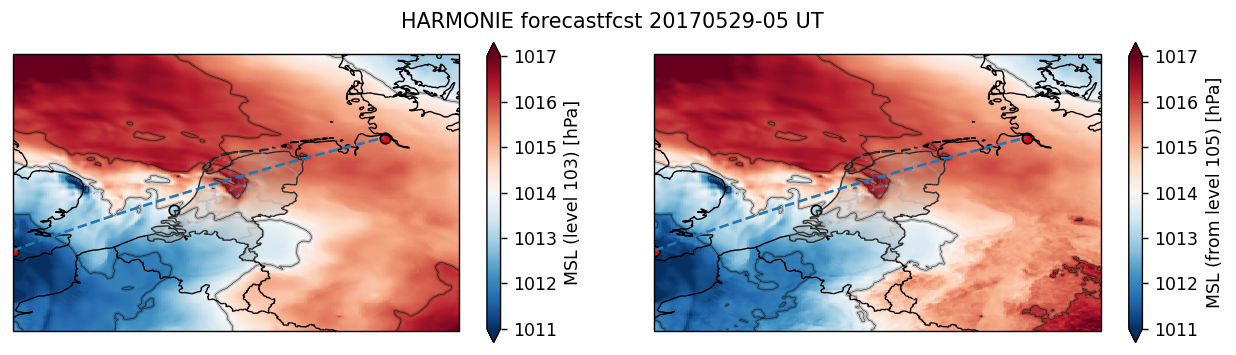

In [15]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,3),
                       subplot_kw={'projection': ccrs.PlateCarree()})

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.15, hspace=0.15)

levels = np.arange(980,1030,2)

msl_pres2.plot(cmap='RdBu_r',
              ax=ax[0],
              robust=True,
               vmin=1011, vmax=1017,
              transform=ccrs.PlateCarree())
msl_pres2.plot.contour(ax=ax[0],
                       colors='black',
                       levels=levels,
                       alpha=0.2,
                       linewidths=2.0, 
                       transform=ccrs.PlateCarree())
msl_pres2.plot.contour(ax=ax[0],
                       colors='black',
                       levels=levels,
                       alpha=0.9,
                       linewidths=0.25, 
                       transform=ccrs.PlateCarree())

msl_pres.plot(cmap='RdBu_r',
              ax=ax[1],
              robust=True,
               vmin=1011, vmax=1017,
              transform=ccrs.PlateCarree())

msl_pres.plot.contour(ax=ax[1],
                       colors='black',
                       levels=levels,
                       alpha=0.2,
                       linewidths=2.0, 
                       transform=ccrs.PlateCarree())
msl_pres.plot.contour(ax=ax[1],
                       colors='black',
                       levels=levels,
                       alpha=0.9,
                       linewidths=0.25, 
                       transform=ccrs.PlateCarree())

for i in range(0,2):
        ax[i].set_title('')
        ax[i].set_extent((lon_.min(), lon_.max(),
                          lat_.min(), lat_.max()))
        # add Borders and so
        ax[i].coastlines(linewidth=.8, edgecolor='gray')
        ax[i].add_feature(BORDERS, linewidth=.8, edgecolor='black')
        # add Dutch provinces
        ax[i].add_geometries(prov2018, ccrs.PlateCarree(), linewidth=1.0,
                          edgecolor='darkgray', facecolor='gray', alpha=0.2)
        
        
        ax[i].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree())
        ax[i].scatter(path_params['start']['lon']%360,
                        path_params['start']['lat'],
                        c='red', edgecolor='black', transform=ccrs.PlateCarree())
        ax[i].scatter(path_params['end']['lon']%360,
                        path_params['end']['lat'],
                        c='red', edgecolor='black', transform=ccrs.PlateCarree())
        ax[i].scatter(lon%360, lat,
                        c='lightblue', edgecolor='black', transform=ccrs.PlateCarree())
        
title_str = '{model} forecastfcst {time} UT'.format(
    model=my_atmos.model, time=t_fcst)
fig.suptitle(title_str)
fig.savefig('msl_103_105_comparison.png', facecolor='white', bbox_inches = 'tight')

## Plot difference

In [16]:
msl3 = msl_pres - msl_pres2

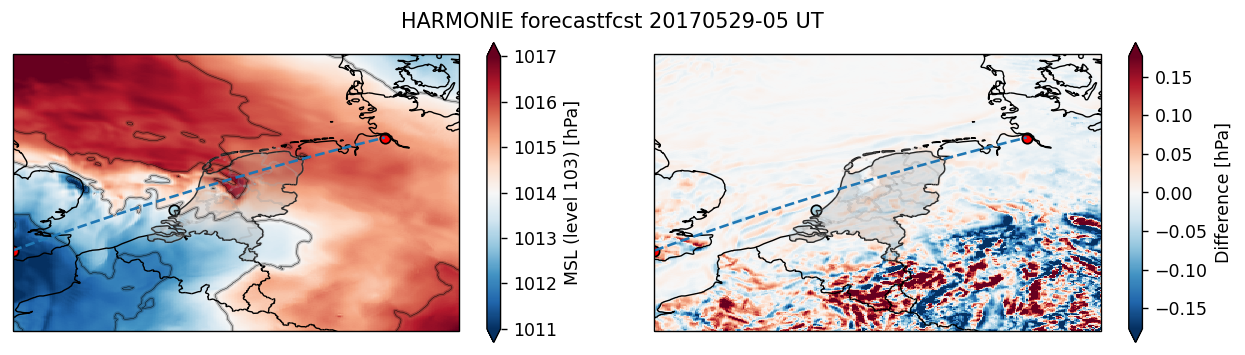

In [17]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,3),
                       subplot_kw={'projection': ccrs.PlateCarree()})

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.15, hspace=0.15)

levels = np.arange(980,1030,2)

# ds['z'].sel(hybrid=60).plot(cmap='terrain',
#                               ax=ax[0],
#                               robust=True,
#                               transform=ccrs.PlateCarree())
msl_pres2 = ds_msl['msl'] / 1e2

msl_pres2.attrs={'long_name': 'MSL (level 103)',
                    'units' : 'hPa',
                    'standard_name': 'MSL (level 103)'}

msl_pres2.plot(cmap='RdBu_r',
              ax=ax[0],
              robust=True,
               vmin=1011, vmax=1017,
              transform=ccrs.PlateCarree())
msl_pres2.plot.contour(ax=ax[0],
                       colors='black',
                       levels=levels,
                       alpha=0.2,
                       linewidths=2.0, 
                       transform=ccrs.PlateCarree())
msl_pres2.plot.contour(ax=ax[0],
                       colors='black',
                       levels=levels,
                       alpha=0.9,
                       linewidths=0.25, 
                       transform=ccrs.PlateCarree())

msl3.attrs={'long_name': 'Difference',
                    'units' : 'hPa',
                    'standard_name': 'Difference'}

msl3.plot(cmap='RdBu_r',
              ax=ax[1],
              robust=True,
              transform=ccrs.PlateCarree())

for i in range(0,2):
        ax[i].set_title('')
        ax[i].set_extent((lon_.min(), lon_.max(),
                          lat_.min(), lat_.max()))
        # add Borders and so
        ax[i].coastlines(linewidth=.8, edgecolor='gray')
        ax[i].add_feature(BORDERS, linewidth=.8, edgecolor='black')
        # add Dutch provinces
        ax[i].add_geometries(prov2018, ccrs.PlateCarree(), linewidth=1.0,
                          edgecolor='darkgray', facecolor='gray', alpha=0.2)
        
        
        ax[i].plot(lons, lats, linestyle='dashed', transform=ccrs.PlateCarree())
        ax[i].scatter(path_params['start']['lon']%360,
                        path_params['start']['lat'],
                        c='red', edgecolor='black', transform=ccrs.PlateCarree())
        ax[i].scatter(path_params['end']['lon']%360,
                        path_params['end']['lat'],
                        c='red', edgecolor='black', transform=ccrs.PlateCarree())
        ax[i].scatter(lon%360, lat,
                        c='lightblue', edgecolor='black', transform=ccrs.PlateCarree())
        
title_str = '{model} forecastfcst {time} UT'.format(
    model=my_atmos.model, time=t_fcst)
fig.suptitle(title_str)
fig.savefig('msl_103_105_difference.png', facecolor='white', bbox_inches = 'tight')